In [3]:
from scipy.integrate import quad, trapz, fixed_quad
import theano
import theano.tensor as T
from theano.tests.unittest_tools import verify_grad
from theano.compile.ops import as_op

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

import astropy.units as u

from tqdm import tqdm

from gammapy.spectrum import CountsPredictor, CountsSpectrum

from utils import load_spectrum_observations, plot_spectra, Log10Parabola, integrate_spectrum, wstat_profile
from forward_fold_model import model_probability, ln_profile_likelihood

%matplotlib inline

In [4]:
def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to(u.TeV).value, fit_range.to(u.TeV).value )
    return [a[idx[0]:idx[1]] for a in arr]

In [286]:
obs_list, fit_range = load_spectrum_observations('magic')
observation = obs_list[0]
exposure_ratio = observation.alpha[0]
energy_bins = observation.on_vector.energy.bins
observation, fit_range# [obs.alpha for obs in observations]


(<gammapy.spectrum.observation.SpectrumObservation at 0x7fa14d549630>,
 <Quantity [ 0.08, 30.  ] TeV>)

In [287]:
'e_true', observation.edisp.e_true.lo.shape, 'e_reco',  observation.edisp.e_reco.lo.shape

('e_true', (108,), 'e_reco', (72,))

In [288]:
def response(mu_sig, edisp, fit_range=None, ):
    edisp = edisp.pdf_matrix
    edisp = T.constant(edisp)

    counts = T.dot(mu_sig, edisp)
    return counts

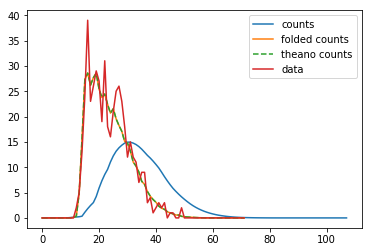

In [289]:
model = Log10Parabola(
    amplitude=4.2 * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=2.6 * u.Unit(''),
    beta=0.43 * u.Unit(''),
)
bins = observation.edisp.e_true.bins.to(u.TeV)
flux = np.array([model.integral(emin=a, emax=b).value for a, b in zip(bins[:-1], bins[1:])]) / (u.s * u.cm**2)
counts  = flux *  observation.aeff.data.data * observation.livetime
counts = counts.value
folded_counts = counts @ observation.edisp.pdf_matrix

mu_sig = T.dvector('mu_sig')
theano_folded_counts = response(mu_sig, observation.edisp)
r  = theano_folded_counts.eval({mu_sig: counts})

on_data, off_data = get_observed_counts([observation])

plt.plot(counts, label='counts')

plt.plot(folded_counts + exposure_ratio*off_data, label='folded counts')
plt.plot(r + exposure_ratio*off_data, label='theano counts', ls='--')
plt.plot(on_data, label='data')
plt.legend()

# plt.figure()
# plt.plot(counts / observation.aeff.data.data / observation.livetime)
# plt.yscale('log')

In [290]:
def get_observed_counts(observations, fit_range=None):
    on_data = []
    off_data = []
    
    for observation in observations:
        on_data.append(observation.on_vector.data.data.value)
        off_data.append(observation.off_vector.data.data.value)
    
    on_data = np.sum(on_data, axis=0)
    off_data = np.sum(off_data, axis=0)
    if fit_range:
        on_data, off_data = apply_range(on_data, off_data, fit_range=fit_range, bins=energy_bins)
    
    return on_data, off_data

In [291]:
on_data = observation.on_vector.data.data.value
off_data = observation.off_vector.data.data.value
    
# on_data, off_data, obs_alpha = apply_range(on_data, off_data, observation.alpha, fit_range=fit_range, bins=energy_bins)

exposure_ratio = observation.alpha[0]   # 1/9 = 0.11111

model = pm.Model(theano_config={'compute_test_value': 'ignore'})
with model:
    mu_b = pm.HalfFlat('mu_b', shape=len(off_data))
    

    #     print(len(observation.on_vector.data.data), on_data.shape, off_data.shape)
    mu_s = pm.HalfFlat('mu_s', shape=len(observation.edisp.e_true.lo))
    expected_counts = response(mu_s, edisp=observation.edisp)

    #     print(expected_counts.shape)
    b = pm.Poisson('background', mu=mu_b, observed=off_data)    
    s = pm.Poisson('signal', mu = expected_counts + exposure_ratio * mu_b, observed=on_data)

In [292]:
model.test_point, model.test_point['mu_b_log__'].shape, model.test_point['mu_s_log__'].shape

({'mu_b_log__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]),
  'mu_s_log__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.])},
 (72,),
 (108,))

In [293]:
with model:
#     step1 = pm.Metropolis([mu_b])
#     step2 = pm.NUTS([amplitude, alpha, beta], target_accept=0.9)
#     trace = pm.sample(1000, step=[step1, step2], chains=5, cores=5)
    trace = pm.sample(1500, chains=5, cores=5, init='auto', target_accept=0.95, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [mu_s, mu_b]
Sampling 5 chains: 100%|██████████| 12500/12500 [00:14<00:00, 839.84draws/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa14d252160>,
      dtype=object)

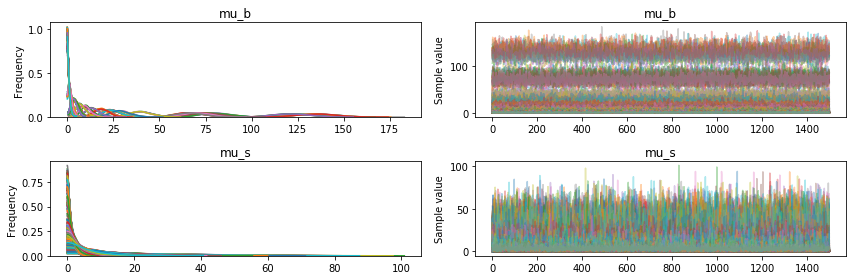

In [294]:
pm.traceplot(trace)

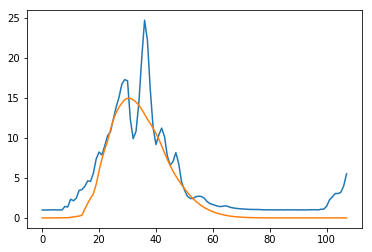

In [295]:
# plt.plot(map_estimate['mu_b'])
plt.plot(np.mean(trace['mu_s'], axis=0))
# plt.plot(trace['mu_b'].mean(axis=0))
# plt.plot(on_data)
plt.plot(counts, label='counts')
# plt.yscale('log')

/home/kbruegge/envs/gammapy/lib/python3.7/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf3fea2eb8>,
      dtype=object)

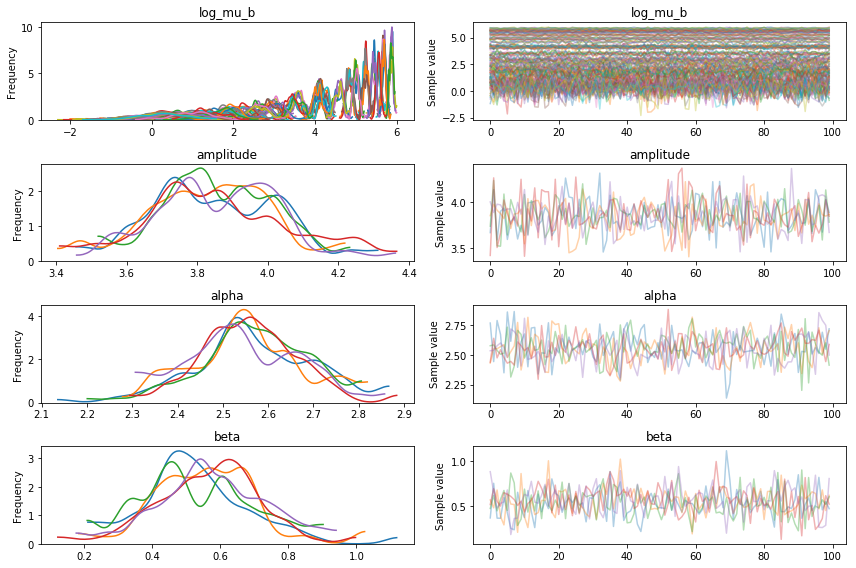

In [65]:
pm.traceplot(trace)

In [297]:
with model:
    samples = pm.sample_ppc(trace)


  0%|          | 0/1500 [00:00<?, ?it/s]

ValueError: Cannot sample from HalfFlat distribution

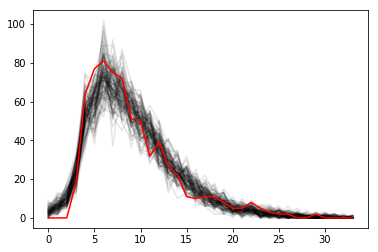

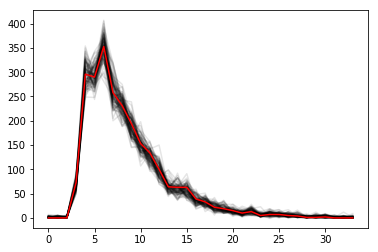

In [88]:
plt.figure()
plt.plot(samples['signal'].T, color='k', alpha=0.1)
plt.plot(on_data, color='red')

plt.figure()
plt.plot(samples['background'].T, color='k', alpha=0.1)
plt.plot(off_data, color='red')

None

In [94]:
pm.summary(trace).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
log_mu_b__0,0.266,0.611,0.022,-0.907,1.385,785.403,1.000
log_mu_b__1,0.252,0.651,0.024,-1.128,1.431,890.927,0.998
log_mu_b__2,0.266,0.621,0.024,-0.895,1.428,817.294,1.001
log_mu_b__3,4.228,0.117,0.004,4.017,4.454,1208.617,0.998
log_mu_b__4,5.695,0.053,0.002,5.593,5.800,1151.206,0.999
log_mu_b__5,5.683,0.056,0.002,5.577,5.802,1904.593,0.996
log_mu_b__6,5.867,0.050,0.002,5.771,5.963,724.297,1.000
log_mu_b__7,5.556,0.064,0.002,5.435,5.686,1394.629,0.997
log_mu_b__8,5.437,0.066,0.002,5.301,5.566,1595.474,0.996
log_mu_b__9,5.239,0.071,0.002,5.110,5.396,1070.531,0.998


In [95]:
trace['amplitude'].mean(), trace['alpha'].mean(), trace['beta'].mean()

(3.8503866, 2.5567994, 0.54980445)

In [96]:
np.median(trace['amplitude']), np.median(trace['alpha']), np.median(trace['beta'])

(3.8444183, 2.5514915, 0.54464173)

In [97]:
# display the total number and percentage of divergent
divergent = trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(trace) * 100
print('Percentage of Divergent %.1f' % divperc)

Number of Divergent 0
Percentage of Divergent 0.0


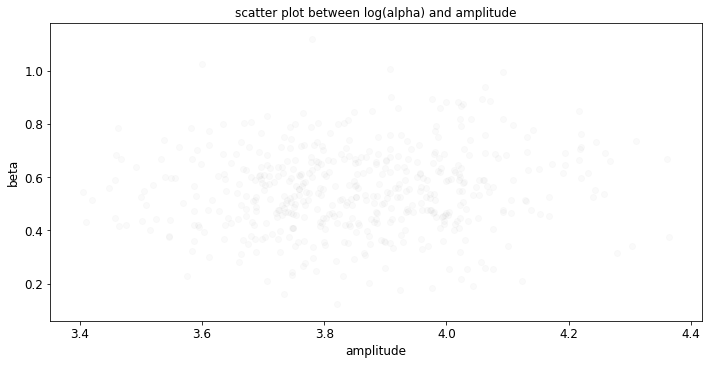

In [98]:
pm.pairplot(trace,
           sub_varnames=['amplitude', 'beta'],
           divergences=True,
           color='k', alpha=0.02, figsize=(10, 5), kwargs_divergence={'color':'C2'})
plt.title('scatter plot between log(alpha) and amplitude');

In [112]:
from collections import defaultdict
divergent_point = defaultdict(list)

chain_warn = trace.report._chain_warnings
for i in range(len(chain_warn)):
    for warning_ in chain_warn[i]:
        if warning_.step is not None and warning_.extra is not None:
            for RV in model.free_RVs:
                para_name = RV.name
                divergent_point[para_name].append(warning_.extra[para_name])

for RV in model.free_RVs:
    para_name = RV.name
    divergent_point[para_name] = np.asarray(divergent_point[para_name])

ii = 5
amplitude_log_d = divergent_point['amplitude_log__']
# print(divergent_point)
mu_5_d = divergent_point['log_mu_b'][:, ii]
Ndiv_recorded = len(divergent_point['log_mu_b'])
mu_5_d

IndexError: too many indices for array

KeyError: 'mu_b_log___5'

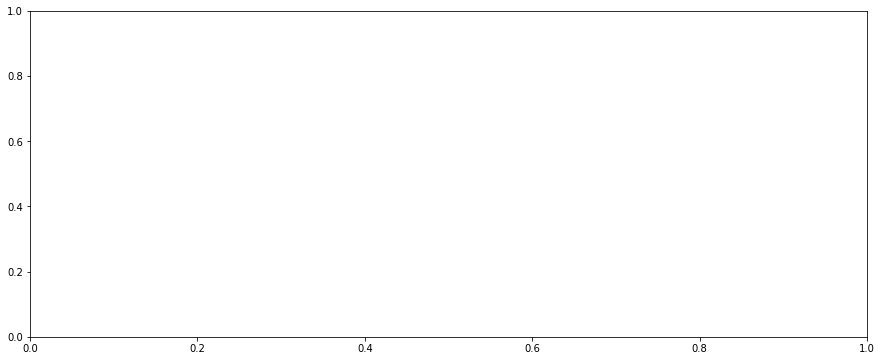

In [104]:
param = 'alpha_log__'
parameter_log_divergence = divergent_point[param]

_, ax = plt.subplots(1, 1, figsize=(15, 6))
pm.pairplot(trace,
               sub_varnames=['mu_b_log___5', param],
               divergences=True,
               ax=ax,
               color='C7', alpha=0.2, figsize=(12, 10),
               kwargs_divergence={'color':'C2', 'label':'Divergent samples'})

mu_trace = trace['mu_b_log__']
mu_0 = mu_trace[:, 5]

plt.plot([mu_0[divergent == 1][:Ndiv_recorded], mu_0_d], 
         [trace[param][divergent == 1][:Ndiv_recorded], parameter_log_divergence], 'k-', alpha=.25)

plt.scatter(mu_0_d, parameter_log_divergence,
              color='C3', alpha=.9, label='Location of Energy error (start location of leapfrog)')
# ax.scatter(divsp.T, 'C3', lw=.5)
# plt.title('scatter plot between log(tau) and theta[0]')
plt.legend()


In [113]:
tracedf = pm.trace_to_dataframe(trace)
plotorder = ['amplitude', 'alpha', 'beta'] + [f'mu_b__{i}' for i in range(len(off_data))]
tracedf = tracedf[plotorder]

_, ax = plt.subplots(1, 1, figsize=(12, 5))
# ax.plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
# ax[0].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)

ax.plot(tracedf.values[divergent == 0].T, color='k', alpha=.01)
ax.plot(tracedf.values[divergent == 1].T, color='C2', lw=2)
divsp = np.hstack([divergent_point['amplitude_log__'][:,None],
                   divergent_point['alpha_log__'][:,None],
                   divergent_point['beta_log__'][:,None],
                   divergent_point['mu_b_log__']
                  ])
ax.plot(divsp.T, 'C3', lw=.5)

plt.xticks(range(len(off_data)), plotorder)
plt.tight_layout()


KeyError: "['mu_b__0' 'mu_b__1' 'mu_b__2' 'mu_b__3' 'mu_b__4' 'mu_b__5' 'mu_b__6'\n 'mu_b__7' 'mu_b__8' 'mu_b__9' 'mu_b__10' 'mu_b__11' 'mu_b__12' 'mu_b__13'\n 'mu_b__14' 'mu_b__15' 'mu_b__16' 'mu_b__17' 'mu_b__18' 'mu_b__19'\n 'mu_b__20' 'mu_b__21' 'mu_b__22' 'mu_b__23' 'mu_b__24' 'mu_b__25'\n 'mu_b__26' 'mu_b__27' 'mu_b__28' 'mu_b__29' 'mu_b__30' 'mu_b__31'\n 'mu_b__32' 'mu_b__33'] not in index"